# Subreddit Suggester
This notebook is a companion to a Swift Playground that uses CreateML to train a model that predicts which subreddit a post should be submitted to based on a user's title. Not everything is easy to do in Swift yet so this script:

1. Scrapes Reddit for post titles and subreddits via their REST API
2. Preprocesses data to prepare it for training a model
3. Tests the resulting models on anecdotal and real-world data
4. Computes more advanced statistics for our model like a confusion matrix.

## Imports

In [188]:
import requests
import pandas
import json
import os
import sys
import re
import coremltools
import matplotlib.pyplot as pyplot

%matplotlib inline

## Constants

In [234]:
PROJECT_DIR = 'PATH/TO/PROJECT/'

## Scraping data from Reddit

In [180]:
def get_listing(subreddit, sort='top', after=None, limit=25):
    # Set the user agent on the request so we don't get rate limited
    headers = {'User-agent': 'Subreddit Title Bot'}
    url_fmt = 'https://www.reddit.com/r/{subreddit}/{sort}.json'
    url = url_fmt.format(subreddit=subreddit, sort=sort)
    params = {'after': after, 'limit': limit, 't': 'year'}
    response = requests.get(url, params=params, headers=headers)
    print(response.url)
    return response.json()

def parse_listing(data):
    items = []
    for child in data['data']['children']:
        post = child['data']
        item = (post['subreddit'], post['title'])
        items.append(item)
    after = data['data']['after']
    return items, after

def get_n_posts(num_posts, subreddit, sort='top', limit=100):
    posts = []
    after = None
    while len(posts) < num_posts:
        data = get_listing(subreddit, sort=sort, after=after, limit=limit)
        items, after = parse_listing(data)
        # Only keep as many posts as we need
        keep = min(num_posts - len(posts), len(items))
        posts.extend(items[:keep])
        if not after:
            break
    return posts

In [137]:
subreddits = [
    'machinelearning',
    'androiddev',
    'iosprogramming',
    'learnmachinelearning',
    'datascience',
    'funny',
    'AskReddit',
    'todayilearned',
    'science',
    'worldnews',
    'pics',
    'IAmA',
    'gaming',
    'videos',
    'movies',
    'aww',
    'Music',
    'blog',
    'gifs',
    'explainlikeimfive',
    'askscience',
    'EarthPorn',
    'books',
    'television',
    'mildlyinteresting',
    'LifeProTips',
    'Showerthoughts',
    'space'
]

max_posts = 1000
posts = []
for subreddit in subreddits:
    posts.extend(get_n_posts(max_posts, subreddit))

https://www.reddit.com/r/machinelearning/top.json?limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_7bxdyv&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_8gj9ns&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_8f2g6k&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_7nb5nq&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_965zgf&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_86ab1g&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_9jhhvb&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_9iz4ck&limit=100&t=year
https://www.reddit.com/r/machinelearning/top.json?after=t3_7qzs7x&limit=100&t=year
https://www.reddit.com/r/androiddev/top.json?limit=100&t=year
https://www.reddit.com/r/androiddev/top.json?after=t3_9kuo2h&limit=100&t=year
https://www.reddit.com/r/androiddev/top.json?a

https://www.reddit.com/r/pics/top.json?after=t3_7g4mro&limit=100&t=year
https://www.reddit.com/r/pics/top.json?after=t3_8kiyb3&limit=100&t=year
https://www.reddit.com/r/pics/top.json?after=t3_8cwmpy&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_866ch5&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_9pbcqp&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_8tqiqp&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_8c1x8q&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_8ajep6&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_9hqsou&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_862wep&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_9cvqbi&limit=100&t=year
https://www.reddit.com/r/IAmA/top.json?after=t3_96bjoo&limit=100&t=year
https://www.reddit.com/r/gaming/top.json?limit=100&t=year
https://www.reddit.com

https://www.reddit.com/r/books/top.json?after=t3_8u0fw0&limit=100&t=year
https://www.reddit.com/r/television/top.json?limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_8zlxus&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_960eep&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_96olc9&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_9g0mz4&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_9abslh&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_96b9d9&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_93eqwa&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_9sq0v0&limit=100&t=year
https://www.reddit.com/r/television/top.json?after=t3_8rg0i0&limit=100&t=year
https://www.reddit.com/r/mildlyinteresting/top.json?limit=100&t=year
https://www.reddit.com/r/mildlyinteresting/top.json?after=t3_8vb71z&limit=100&t=year
https://w

In [138]:
df = pandas.DataFrame(posts, columns=['subreddit', 'title'])
df.head()

,subreddit,title
0,MachineLearning,[P] Realtime multihand pose estimation demo
1,MachineLearning,[P] Keras Implementation of Image Outpaint
2,MachineLearning,[P] Generative Ramen
3,MachineLearning,[P] Landing the Falcon booster with Reinforcem...
4,MachineLearning,[D] If you had to show one paper to someone to...


In [139]:
# Clean the titles
df.title = df.title.apply(lambda x: re.sub(r'\[.*\]', '', x))
df.title = df.title.apply(lambda x: re.sub(r'\W(?<![ ])', '', x))
df.head()

,subreddit,title
0,MachineLearning,Realtime multihand pose estimation demo
1,MachineLearning,Keras Implementation of Image Outpaint
2,MachineLearning,Generative Ramen
3,MachineLearning,Landing the Falcon booster with Reinforcement...
4,MachineLearning,If you had to show one paper to someone to sh...


In [140]:
# Format everything for CreateML
output = []
for idx, row in df.iterrows():
    output.append({'text': row.title, 'label': row.subreddit})

In [141]:
filename = os.path.join(PROJECT_DIR, 'data.json')
with open(filename, 'w') as fid:
    fid.write(json.dumps(output))

# Test Model
Head over to the Swift Playground code to train your model before continuing.

In [143]:
mlmodel = coremltools.models.MLModel(
    os.path.join(PROJECT_DIR, 'SubredditSuggester.mlmodel')
)

In [144]:
mlmodel._spec.description

input {
  name: "text"
  shortDescription: "Input text"
  type {
    stringType {
    }
  }
}
output {
  name: "label"
  shortDescription: "Text label"
  type {
    stringType {
    }
  }
}
metadata {
  shortDescription: "Predict which subreddit a post should go in based on a title."
  versionString: "1.0"
  author: "Jameson Toole"
}

In [233]:
# Test the model on some titles I wrote with specific subreddits in mind.
sample_titles = [
    'Saw this good boy at the park today.',
    'Latest NIPS submission from OpenAI',
    'TIL you can use Core ML to suggest subreddits to users',
    'I made a tutorial using CreateML AMA',
    'Westworld and Game of Thrones coming to netflix',
    'We park in driveways, but drive on parkways',
    'From the top of Mt. Fuji, Japan',
    "What's the first thing you do every morning?",
    'Taylor Swift announces additional Reputation tour dates'
]

for title in sample_titles:
    result = mlmodel.predict({'text': title})
    print(title, ' | ', result['label'])

Saw this good boy at the park today.  |  aww
Latest NIPS submission from OpenAI  |  MachineLearning
TIL you can use Core ML to suggest subreddits to users  |  todayilearned
I made a tutorial using CreateML AMA  |  IAmA
Westworld and Game of Thrones coming to netflix  |  television
We park in driveways, but drive on parkways  |  Showerthoughts
From the top of Mt. Fuji, Japan  |  EarthPorn
What's the first thing you do every morning?  |  AskReddit
Taylor Swift announces additional Reputation tour dates  |  iOSProgramming


In [181]:
# Download 100 new posts from each subreddit.
max_posts = 100
posts = []
for subreddit in subreddits:
    posts.extend(get_n_posts(max_posts, subreddit))

https://www.reddit.com/r/machinelearning/new.json?limit=100
https://www.reddit.com/r/androiddev/new.json?limit=100
https://www.reddit.com/r/iosprogramming/new.json?limit=100
https://www.reddit.com/r/learnmachinelearning/new.json?limit=100
https://www.reddit.com/r/datascience/new.json?limit=100
https://www.reddit.com/r/funny/new.json?limit=100
https://www.reddit.com/r/AskReddit/new.json?limit=100
https://www.reddit.com/r/todayilearned/new.json?limit=100
https://www.reddit.com/r/science/new.json?limit=100
https://www.reddit.com/r/worldnews/new.json?limit=100
https://www.reddit.com/r/pics/new.json?limit=100
https://www.reddit.com/r/IAmA/new.json?limit=100
https://www.reddit.com/r/gaming/new.json?limit=100
https://www.reddit.com/r/videos/new.json?limit=100
https://www.reddit.com/r/movies/new.json?limit=100
https://www.reddit.com/r/aww/new.json?limit=100
https://www.reddit.com/r/Music/new.json?limit=100
https://www.reddit.com/r/blog/new.json?limit=100
https://www.reddit.com/r/gifs/new.json?

In [182]:
# Apply the same pre-processing
new_df = pandas.DataFrame(posts, columns=['subreddit', 'title'])
new_df.title = new_df.title.apply(lambda x: re.sub(r'\[.*\]', '', x))
new_df.title = new_df.title.apply(lambda x: re.sub(r'\W(?<![ ])', '', x))
new_df.head()

,subreddit,title
0,MachineLearning,Applying Deep Learning To Airbnb Search
1,MachineLearning,What is the best way to isolate a feature of ...
2,MachineLearning,Model a wifi system
3,MachineLearning,BERT Explained State of the art language mode...
4,MachineLearning,Massive automated archivehistorical footage s...


In [184]:
# Predict the subreddit for each post.
new_df['predicted'] = new_df.title.apply(lambda x: mlmodel.predict({'text': x})['label'])

In [185]:
# Mark a prediction correct if it matches the actual subreddit
new_df['correct'] = new_df.predicted == new_df.subreddit

In [186]:
# Compute the accuracy
new_df.correct.sum() / new_df.shape[0]

0.5553571428571429

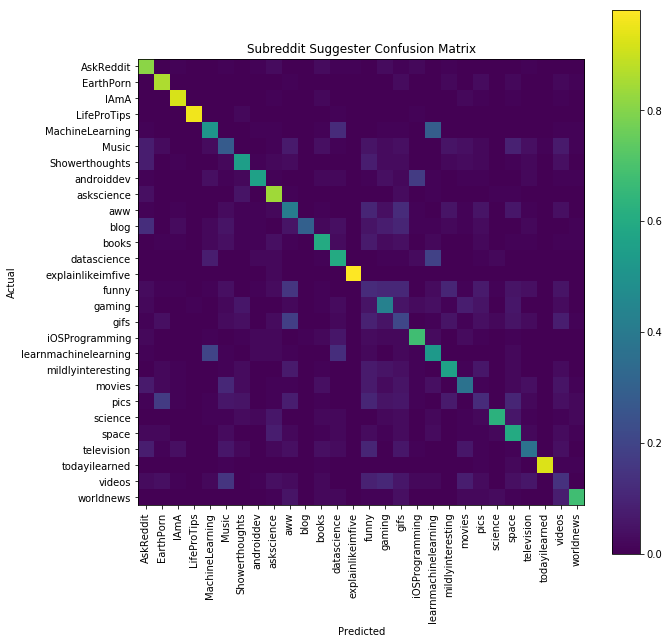

In [232]:
# Create a Confusion Matrix
confusion_df = new_df[['subreddit', 'predicted', 'correct']].pivot_table(index='subreddit', columns='predicted', values='correct', aggfunc='count', fill_value=0)
confusion = confusion_df.values / 100.0

pyplot.imshow(confusion)
pyplot.xticks(range(confusion.shape[0]), confusion_df.columns.values, rotation=90)
pyplot.yticks(range(confusion.shape[1]), confusion_df.index.values)
pyplot.xlabel('Predicted')
pyplot.ylabel('Actual')
pyplot.title('Subreddit Suggester Confusion Matrix')
pyplot.colorbar()

pyplot.gcf().set_size_inches(10, 10)
fig = pyplot.gcf()